In [1]:
%load_ext autoreload
%autoreload 2

import time
import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData
from memflow.dataset.dataset import CombinedDataset
from memflow.HH.HH import HHbbWWDoubleLeptonHardDataset,HHbbWWDoubleLeptonRecoDataset
from memflow.callbacks.transfer_flow_callbacks import *
from memflow.models.custom_flows import *

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

# Dataset preparation

In this section, we will load and prepare the datasets for feeding through the transfer model.

Some of the steps of making particles and selecting events is already done in the classes
- HHbbWWDoubleLeptonHardDataset
- HHbbWWDoubleLeptonRecoDataset

We will first get the gen and reco data

In [2]:
hard_data = RootData(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root',
    ],
    treenames = [
        'gen_HH;1',
    ],
    lazy = True,
    #N = 10000,
)

print (hard_data)

Data object
Loaded branches:
   ... file: 1589994
   ... sample: 1589994
   ... tree: 1589994
Branch in files not loaded:
   ... H1_E
   ... H1_Px
   ... H1_Py
   ... H1_Pz
   ... H1_eta
   ... H1_idx
   ... H1_mass
   ... H1_pdgId
   ... H1_phi
   ... H1_pt
   ... H1_sum_E
   ... H2_E
   ... H2_Px
   ... H2_Py
   ... H2_Pz
   ... H2_eta
   ... H2_idx
   ... H2_mass
   ... H2_pdgId
   ... H2_phi
   ... H2_pt
   ... H2_sum_E
   ... ISR_10_E
   ... ISR_10_Px
   ... ISR_10_Py
   ... ISR_10_Pz
   ... ISR_10_eta
   ... ISR_10_idx
   ... ISR_10_mass
   ... ISR_10_parent
   ... ISR_10_pdgId
   ... ISR_10_phi
   ... ISR_10_pt
   ... ISR_11_E
   ... ISR_11_Px
   ... ISR_11_Py
   ... ISR_11_Pz
   ... ISR_11_eta
   ... ISR_11_idx
   ... ISR_11_mass
   ... ISR_11_parent
   ... ISR_11_pdgId
   ... ISR_11_phi
   ... ISR_11_pt
   ... ISR_12_E
   ... ISR_12_Px
   ... ISR_12_Py
   ... ISR_12_Pz
   ... ISR_12_eta
   ... ISR_12_idx
   ... ISR_12_mass
   ... ISR_12_parent
   ... ISR_12_pdgId
   ... ISR_12

In [3]:
reco_data = RootData(
    files = hard_data.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = hard_data.N,
)
print ('Initial :',reco_data.events)

mask_resolved = np.logical_and.reduce(
    (
        reco_data['flag_SR']==1, 
        reco_data['flag_resolved']==1,
        reco_data['n_AK4']<= 8, # We restrict a bit the number of jets that we want to deal with
    )
)
reco_data.cut(mask_resolved)
print ('Resolved SR :',reco_data.events)
print (reco_data)


Initial : 1589994
Resolved SR : 221454
Data object
Loaded branches:
   ... file: 221454
   ... flag_SR: 221454
   ... flag_resolved: 221454
   ... n_AK4: 221454
   ... sample: 221454
   ... tree: 221454
Branch in files not loaded:
   ... VBF1_E
   ... VBF1_Px
   ... VBF1_Py
   ... VBF1_Pz
   ... VBF1_eta
   ... VBF1_idx
   ... VBF1_mass
   ... VBF1_phi
   ... VBF1_pt
   ... VBF1_sel
   ... VBF2_E
   ... VBF2_Px
   ... VBF2_Py
   ... VBF2_Pz
   ... VBF2_eta
   ... VBF2_idx
   ... VBF2_mass
   ... VBF2_phi
   ... VBF2_pt
   ... VBF2_sel
   ... VBF3_E
   ... VBF3_Px
   ... VBF3_Py
   ... VBF3_Pz
   ... VBF3_eta
   ... VBF3_idx
   ... VBF3_mass
   ... VBF3_phi
   ... VBF3_pt
   ... VBF3_sel
   ... VBF4_E
   ... VBF4_Px
   ... VBF4_Py
   ... VBF4_Pz
   ... VBF4_eta
   ... VBF4_idx
   ... VBF4_mass
   ... VBF4_phi
   ... VBF4_pt
   ... VBF4_sel
   ... VBF5_E
   ... VBF5_Px
   ... VBF5_Py
   ... VBF5_Pz
   ... VBF5_eta
   ... VBF5_idx
   ... VBF5_mass
   ... VBF5_phi
   ... VBF5_pt
   ... VBF

We will feed these data objects to the already coded datasets.

Some of the arguments take a while to explain, will add some comments but for more explanation ask me.

In [4]:
hard_dataset = HHbbWWDoubleLeptonHardDataset(
    data = hard_data, 
    selection = [ # even if several particles are defined in the class, we will select here the ones we feed to the ML model
        'leptons',
        'bquarks',
    ],
    coordinates = 'cylindrical', # cylindrical = [pt,eta,phi,m] or cartesian = [px,py,pz,E]
    apply_boost = False, # whether to boost to CM
    apply_preprocessing = True, # apply the preprocessing defined in the class
    build = True, # re-save to directory
    dtype = torch.float32,
)
print (hard_dataset)

Selecting 1519507 events out of 1589994
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/hh_hard
No final state recorded with `final_states_object_name` property, will not compute PS points
Parton dataset with 1519507 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -12, -11, 12]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0, 0.0005109989499999999, 0.0]
Containing the following tensors
leptons  : data ([1519507, 4, 5]), mask ([1519507, 4])
           Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%]
           Mask corr     : [True, True, True, True]
           Weights       : 1519507.00, 1519507.00, 1519507.00, 1519507.00
           Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
           Selected for batches : True
higgs    : data ([1519507, 2, 5]), mask ([1519507, 2])
           Mask exist    : [100.00%, 100.00%]
           Mask corr     : [True, True]
           Weights       : 1519507.00, 1519507.00


In [5]:
reco_dataset = HHbbWWDoubleLeptonRecoDataset(
    data = reco_data,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = { # apply these default features in case they are not present
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None, # remove with None
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print (reco_dataset)

Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/hh_reco
Reco dataset with 221454 events
Containing the following tensors
boost      : data ([221454, 1, 7]), mask ([221454, 1])
             Mask exist    : [100.00%]
             Mask corr     : [True]
             Weights       : 221454.00
             Features      : ['pt', 'eta', 'phi', 'btag', 'pdgId', 'charge', 'mass']
             Selected for batches : False
jets       : data ([221454, 8, 7]), mask ([221454, 8])
             Mask exist    : [100.00%, 99.99%, 55.51%, 23.37%, 8.04%, 2.42%, 0.64%, 0.13%]
             Mask corr     : [True, True, False, False, False, False, False, False]
             Weights       : 221454.00, 221454.00, 221454.00, 221454.00, 221454.00, 221454.00, 221454.00, 221454.00
             Features      : ['pt', 'eta', 'phi', 'btag', 'pdgId', 'charge', 'mass']
             Selected for batches : True
electrons  : data ([221454, 2, 7]), mask ([221454, 2])
             Mask exist    : [64.6

Just to understand a bit better what is in our dataset, we can plot the different quantities for each partycle/type.

We can plot both the raw values, and the ones after pre-processing.

About preprocessing, for several reasons we do not want to feed the raw values to the ML model. 
So we apply different preprocessing schemes (apply a log, standard scaling, min-max scaling, etc), but we still want to check their effect.

Hard-level
Before preprocessing


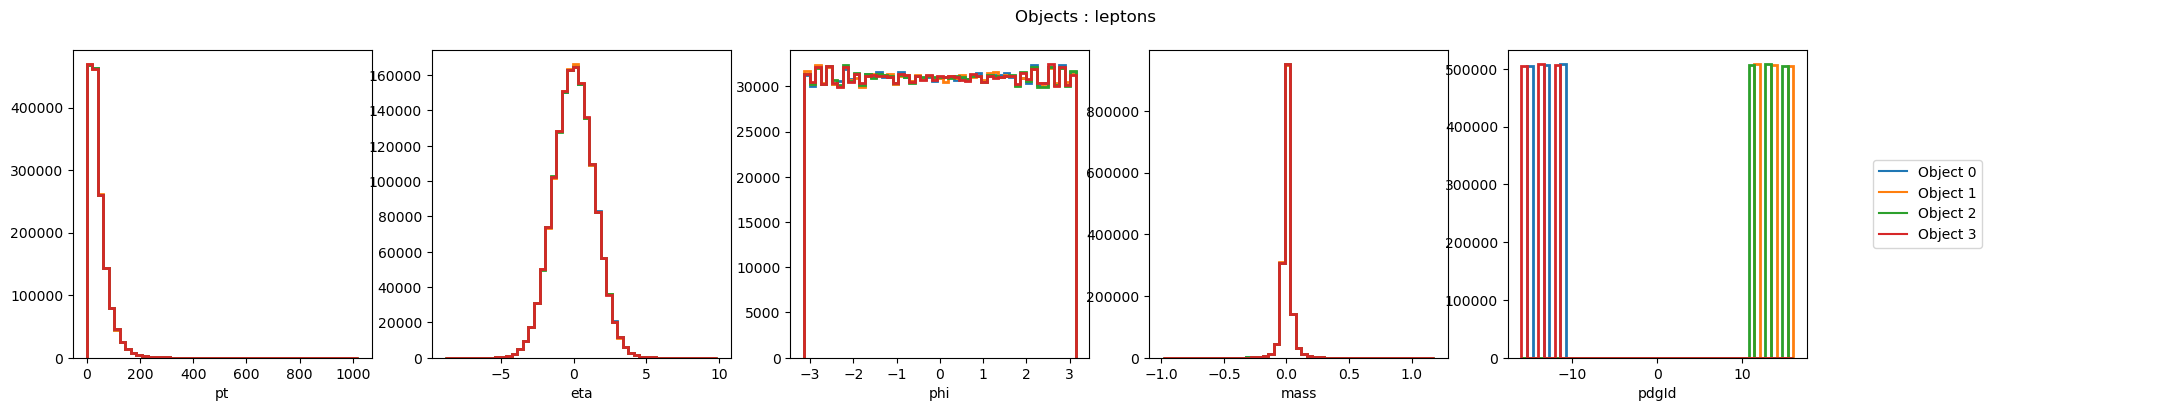

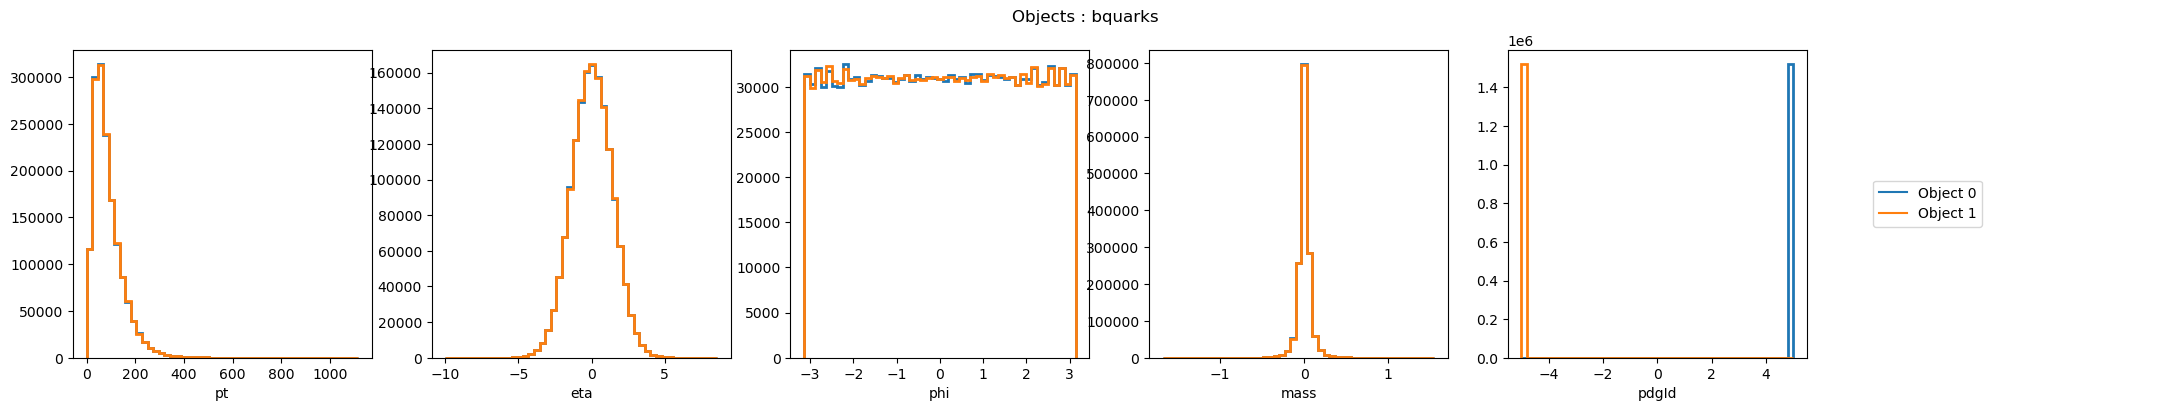

After preprocessing


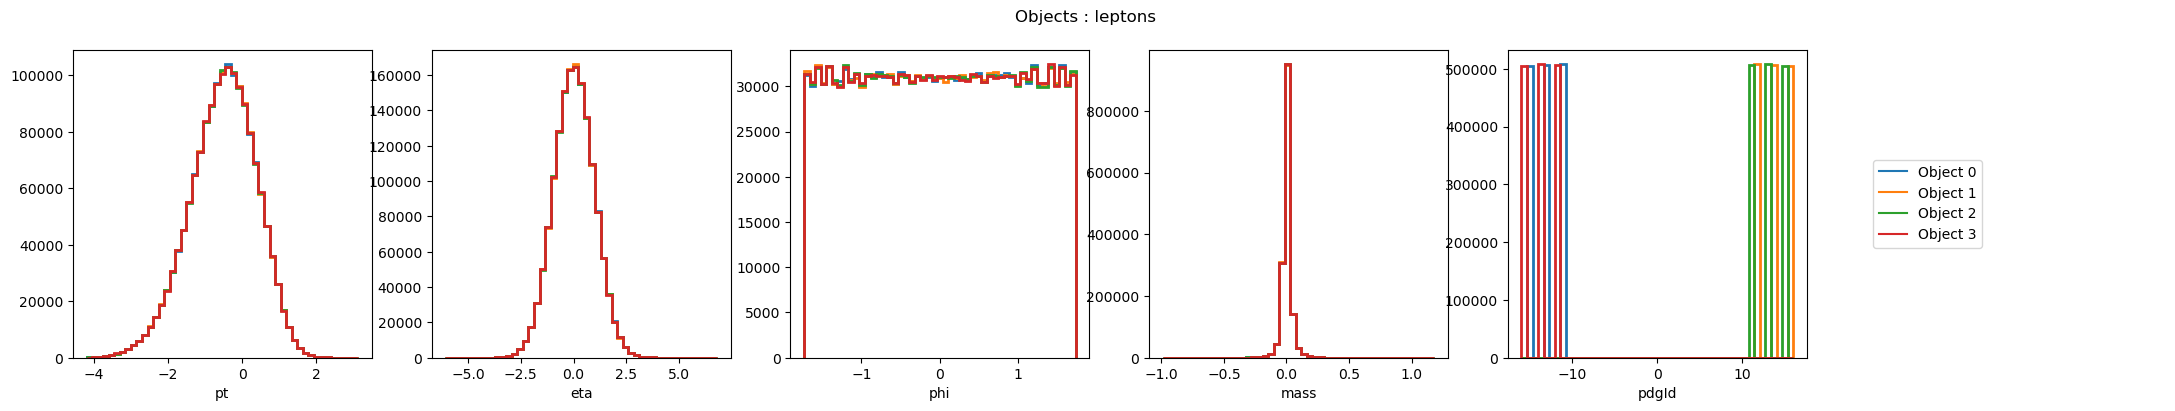

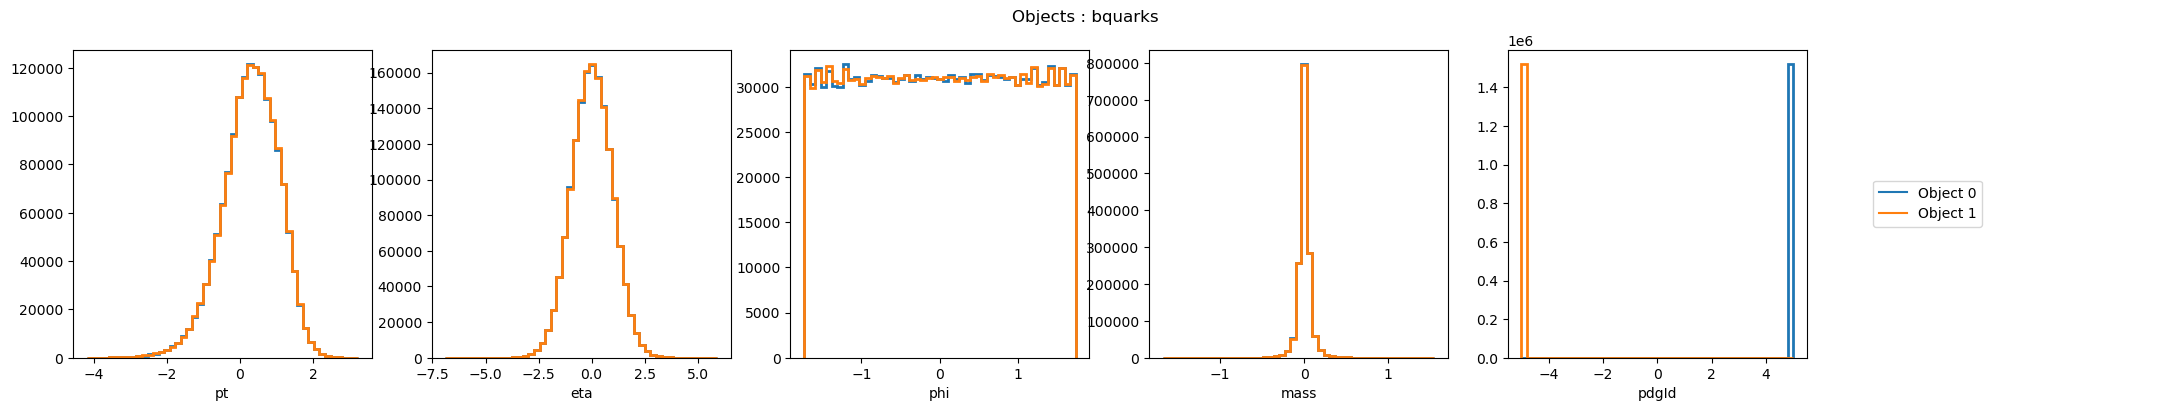

Reco-level
Before preprocessing


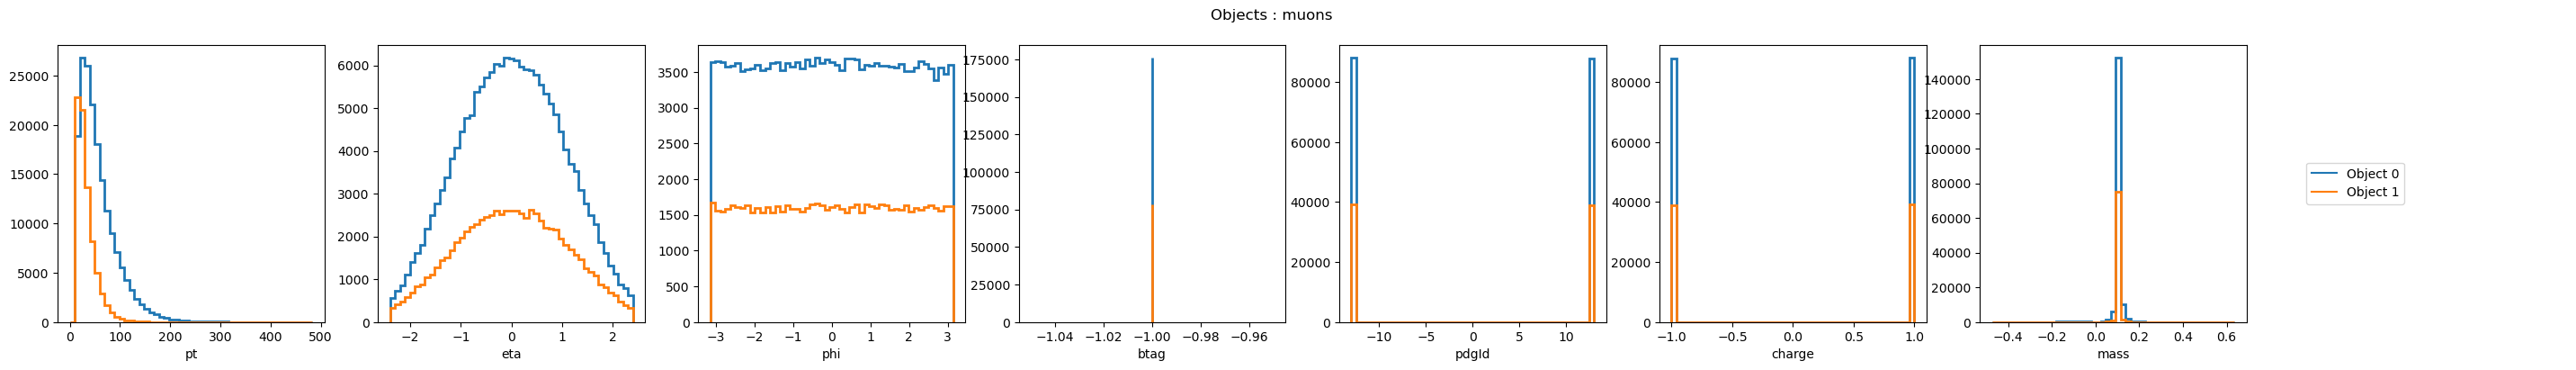

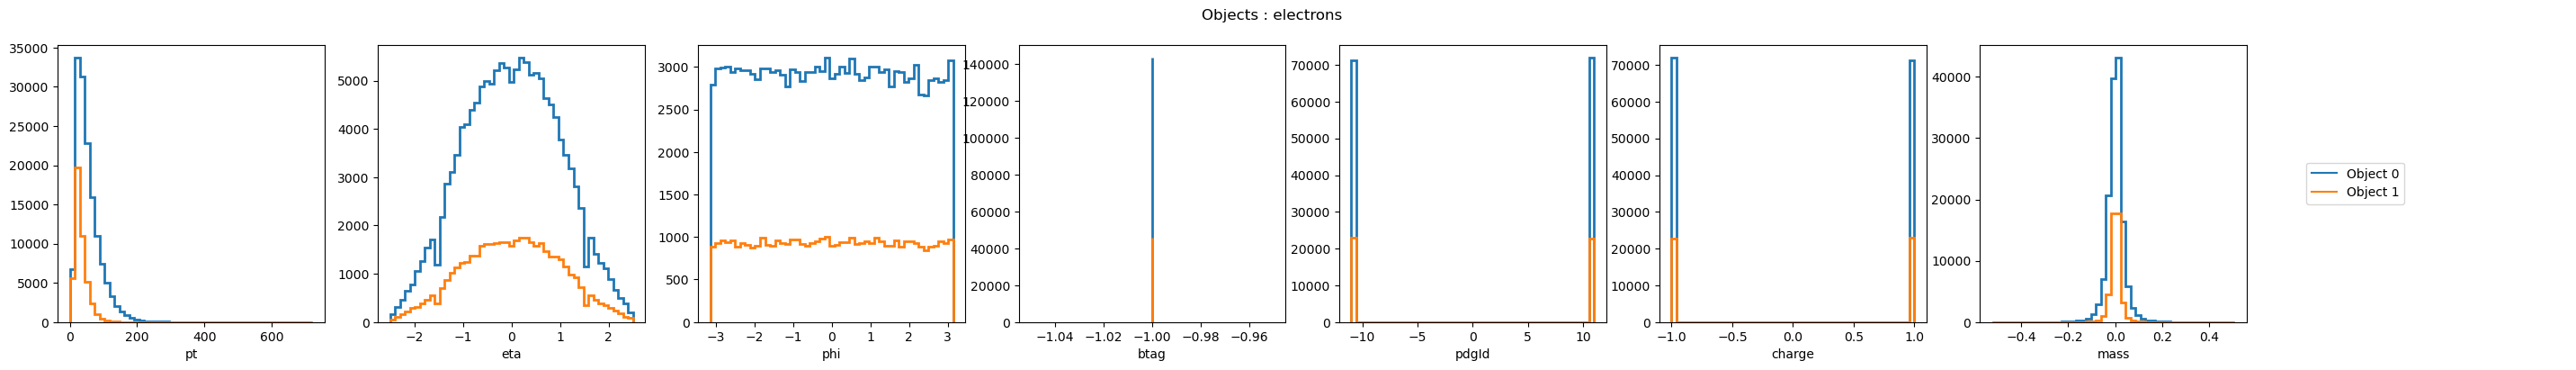

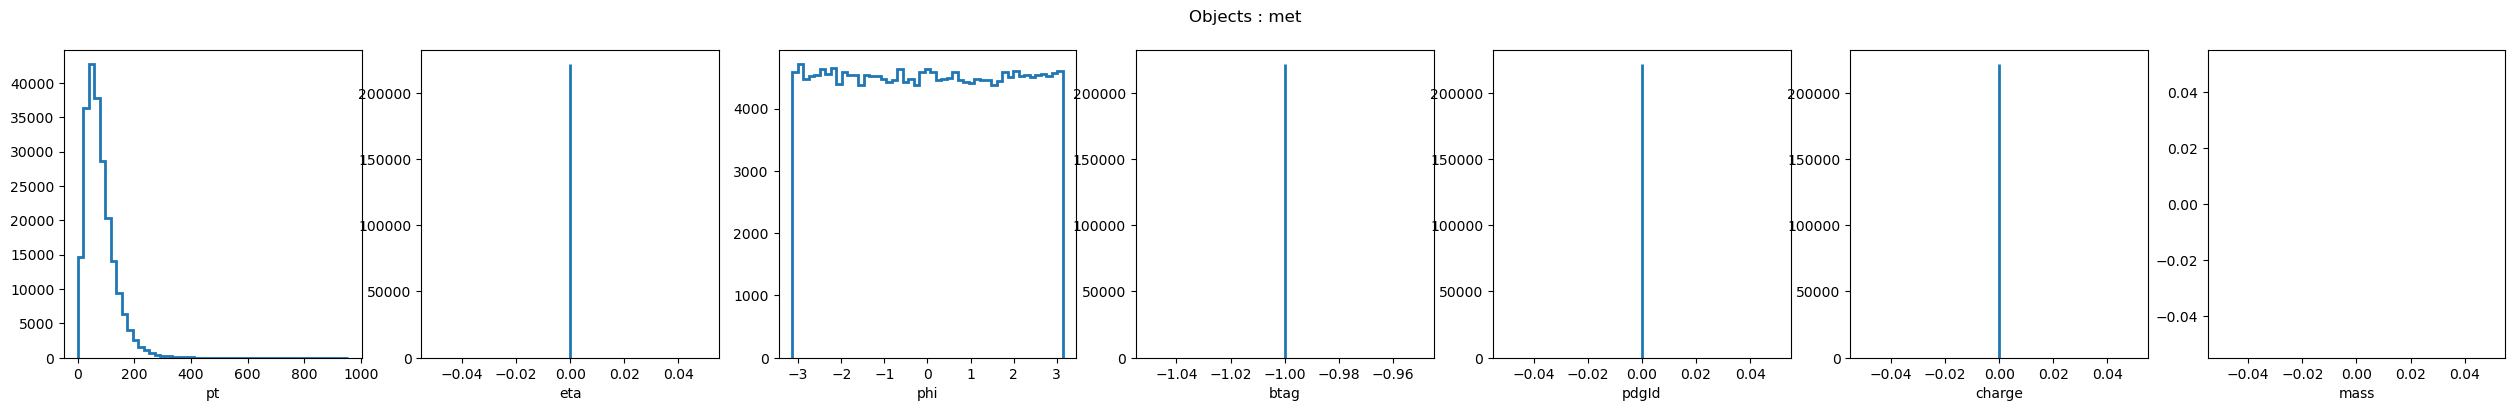

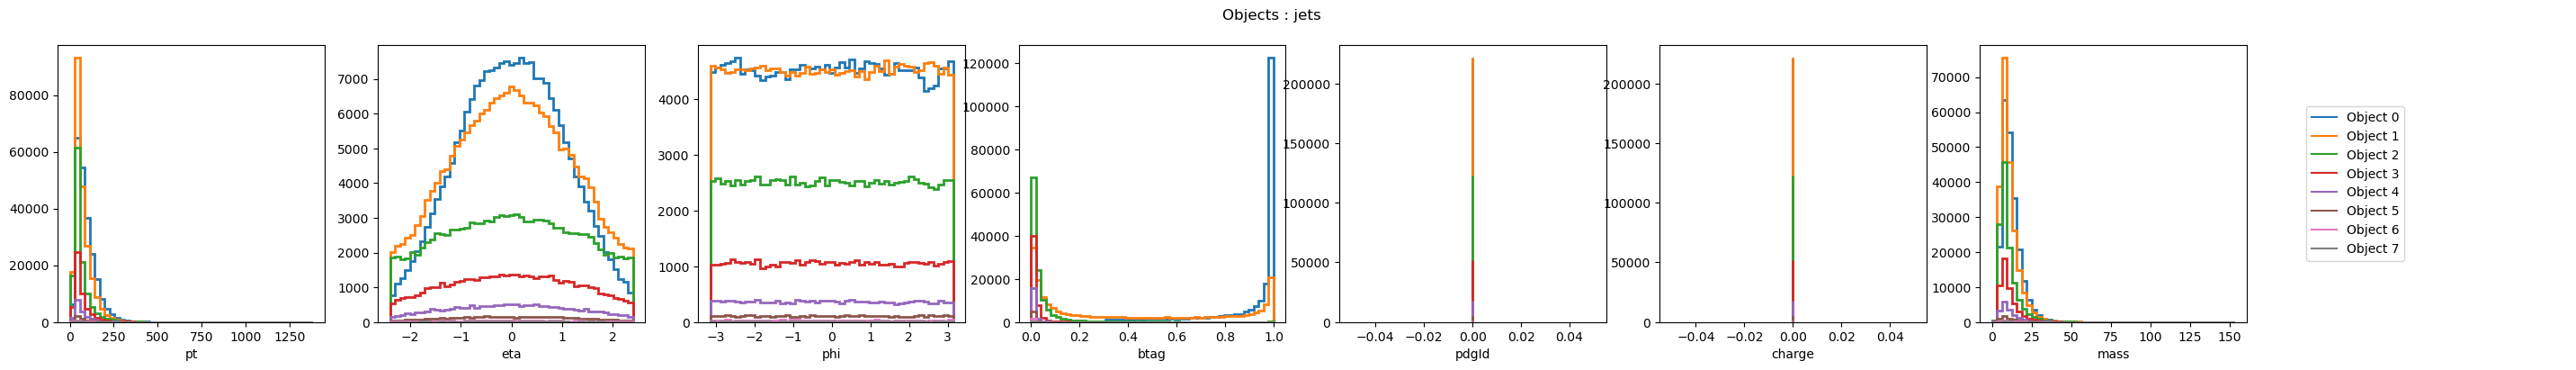

After preprocessing


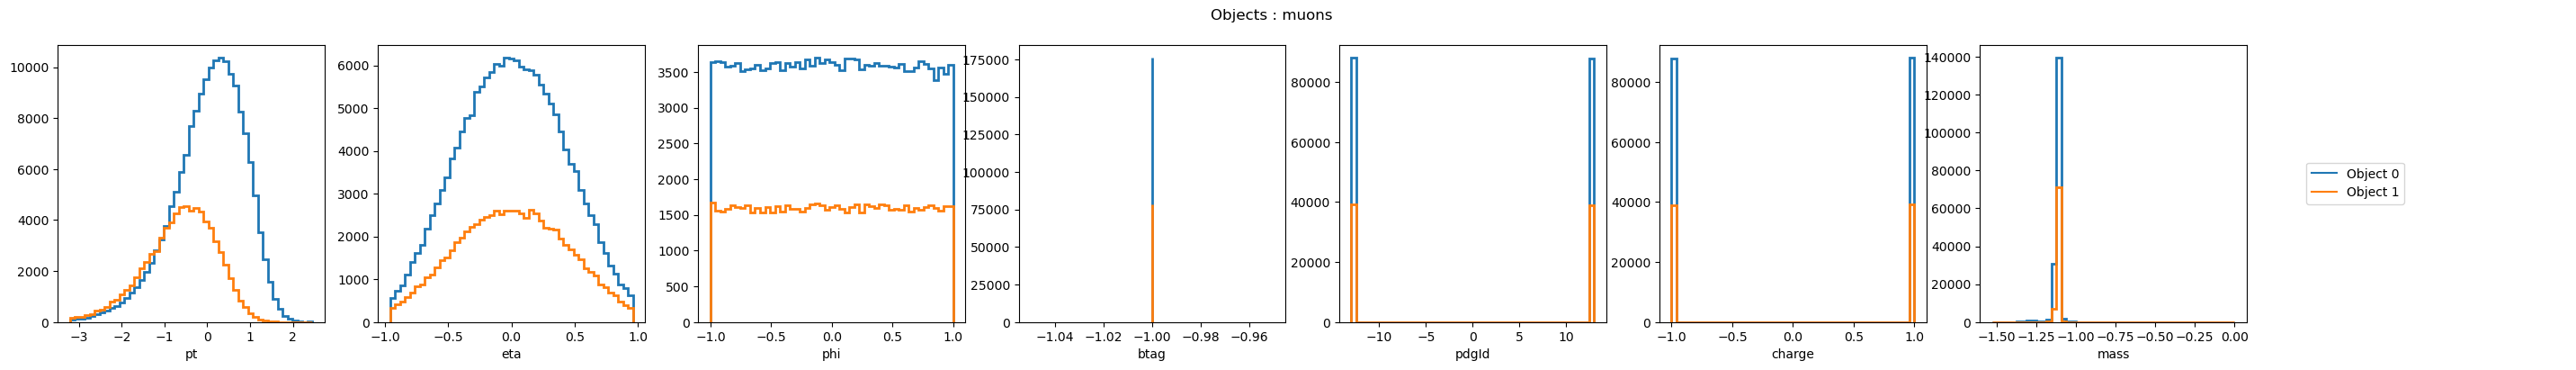

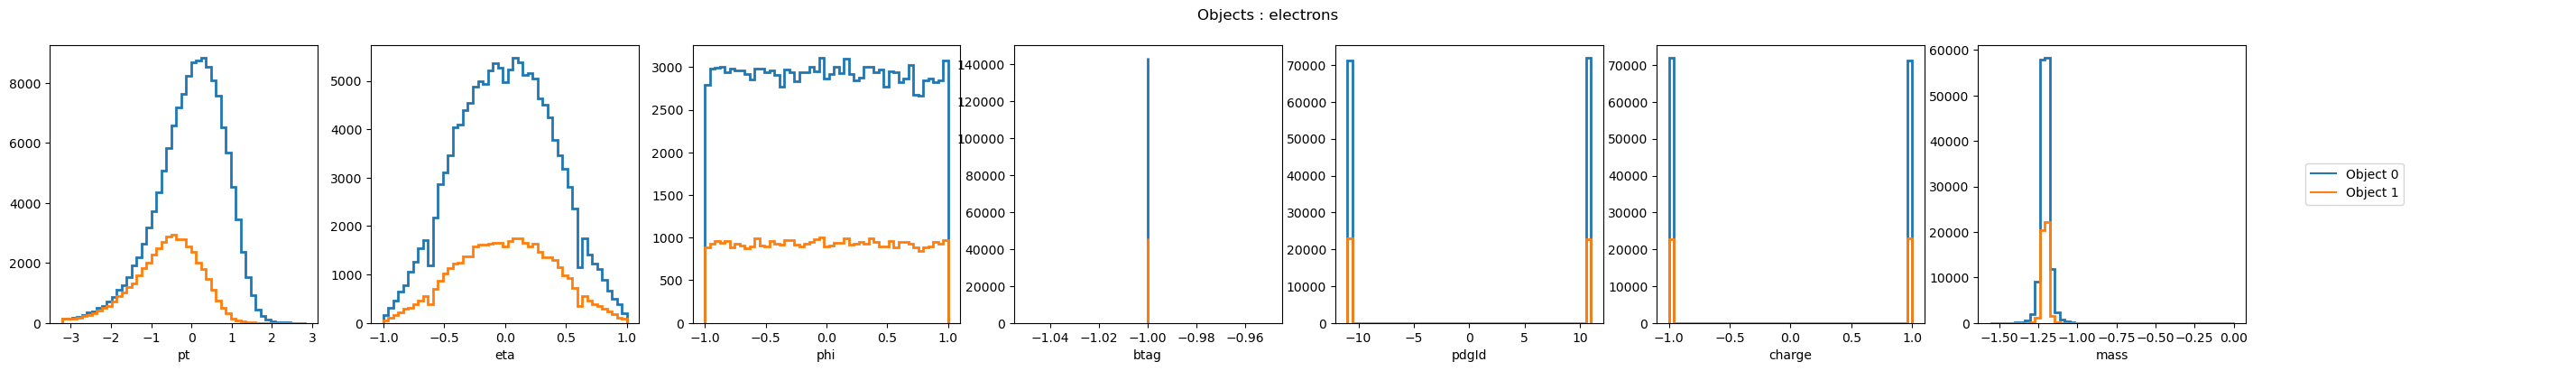

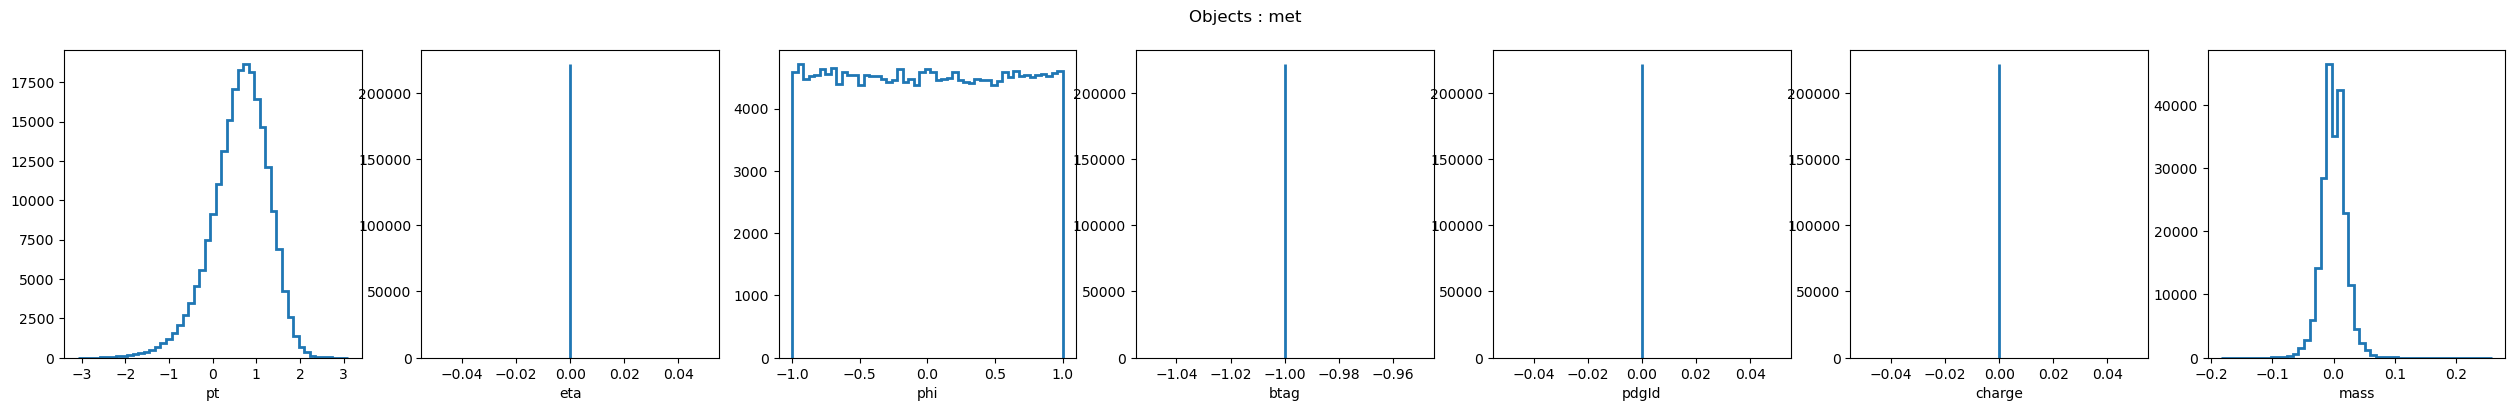

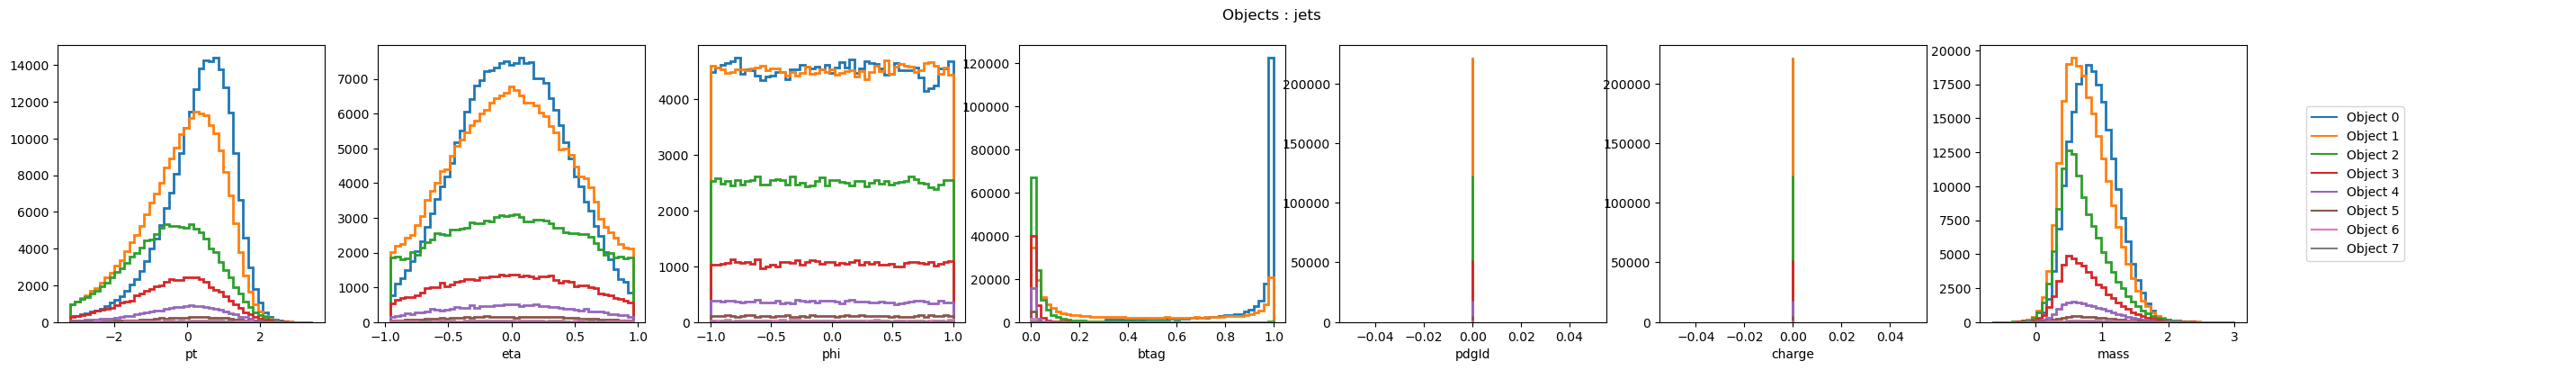

In [6]:
print ('Hard-level')
print ('Before preprocessing')
hard_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
hard_dataset.plot(selection=True,raw=False)

print ('Reco-level')
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False)

Now, we want to combine the reco and gen information.

To avoid doing it by hand, a combined dataset has been created. 

In [7]:
comb_dataset = CombinedDataset(
    hard_dataset = hard_dataset,
    reco_dataset = reco_dataset,
    intersection_branch = 'event',
)
print (comb_dataset)

Looking into file metadata
	entry 0 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root']
	entry 1 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root']
Will only consider common files : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu

In [8]:
# To check what is contained in all our batches, we make a classic pytorch loader, and print the content
loader_comb = DataLoader(
    comb_dataset,
    batch_size = 256,
)
batch = next(iter(loader_comb))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],reco_dataset.selection):
    print ('\t',sel,obj.shape,mask.shape)
print ('Hard')
for obj,mask,sel in zip(batch['hard']['data'],batch['hard']['mask'],hard_dataset.selection):
    print ('\t',sel,obj.shape,mask.shape)


Reco
	 muons torch.Size([256, 2, 7]) torch.Size([256, 2])
	 electrons torch.Size([256, 2, 7]) torch.Size([256, 2])
	 met torch.Size([256, 1, 7]) torch.Size([256, 1])
	 jets torch.Size([256, 8, 7]) torch.Size([256, 8])
Hard
	 leptons torch.Size([256, 4, 5]) torch.Size([256, 4])
	 bquarks torch.Size([256, 2, 5]) torch.Size([256, 2])


The batches that we provide to the loader contain the different types of particles for reco and gen level.
The shape is `[N,S,F]`
- `N` : number of events in the batch (this is the batch size that you decide yourself)
- `S` : sequence length = number of particles (eg, number of electrons, or jets) (see explanation of mask below)
- `F` : number of features (eg, pt, eta, pdgid, btag score, etc) for each particle

For each type of particle we provide the data (actual values in the training) with shape above, but also the mask.
This mask comes from the fact that we need to feed a fixed-size tensor to the ML model, but we do not have fixed size inputs (number of jets can vary for example). So we "pad" the tensors with 0s, but the fact that these particles are missing are saved in the mask that has False's. In the transformer this will be used in the self-attention. The mask has a shape `[N,S]`.

Now we need to split the dataset into a training and validation dataset, and make them into dataloaders.

In [9]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.9
indices = torch.arange(len(comb_dataset))
sep = int(train_frac*len(comb_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

comb_dataset_train = torch.utils.data.Subset(comb_dataset,train_indices)
comb_dataset_valid = torch.utils.data.Subset(comb_dataset,valid_indices)

print (f'There will be {len(comb_dataset_train)} events in the training dataset, and {len(comb_dataset_valid)} in the validation set')

batch_size = 1024

loader_comb_train = DataLoader(
    comb_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_comb_valid = DataLoader(
    comb_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)

There will be 187619 events in the training dataset, and 20847 in the validation set


# Creating the model

A specific pytorch class has been coded for the transfer flow

Most of these arguments would require a lot of text, so will give some cues but can explain later

In [12]:
from memflow.models.transfer_flow_model import TransferFlow

model = TransferFlow(
    # Embedding arguments #
    embed_dims = [32,64], # number of neurons per layer to embed the particle components to higher dimension
    embed_act = nn.GELU,
    # Particle features, names, masks, and number for printouts and logging #
    n_hard_particles_per_type = hard_dataset.number_particles_per_type,
    hard_particle_type_names = hard_dataset.selection,
    hard_input_features_per_type = hard_dataset.input_features,
    n_reco_particles_per_type = reco_dataset.number_particles_per_type,
    reco_particle_type_names = reco_dataset.selection,
    reco_input_features_per_type = reco_dataset.input_features,
    flow_input_features = [ # features to be used in the flows (different from the tranformer)
        ['pt','eta','phi'], # electrons
        ['pt','eta','phi'], # muons
        ['pt','phi'],       # met
        ['pt','eta','phi'], # jets
    ],
    reco_mask_attn = reco_dataset.attention_mask,
    hard_mask_attn = hard_dataset.attention_mask,
    # Transformer arguments #
    onehot_encoding = True, # add onehot encoded position vector to features
    transformer_args = { # to be passed to the Transformer pytorch class
        'nhead' : 8,
        'num_encoder_layers' : 8, 
        'num_decoder_layers' : 8, 
        'dim_feedforward' : 256, 
        'dropout' : 0., 
        'activation' : 'gelu', 
    },
    # Flow args #
    flow_common_args = { # common args for all flows
        'bins' : 32,
        'transforms' : 5,
        'randperm' : True,
        'passes' : None,
        'hidden_features' : [128] * 3,   
    },
    flow_classes = { # classes for each feature
        'pt'  : zuko.flows.NSF,
        'eta' : UniformNSF,
        'phi' : UniformNCSF,
        'pt'  : zuko.flows.NSF,
    },
    flow_specific_args = { # specific args for each class above
        'eta' : {'bound' : 1.},
        'phi' : {'bound' : 1.},
    },
    flow_mode = 'global', # 'global', 'type' or 'particle'
)
model = model.cpu()

# Below are some testing of individual workings of the model
# This is just to make sure there is no bug before running the training loop

# Testing the model #
# We get a single batch from the loader
batch = next(iter(loader_comb))
# This returns the -log(prob), the combined mask and weights
# They all have shape [N,S], as we have a log prob per particle
log_probs, mask, weights = model(batch)
print ('log_probs',log_probs,log_probs.shape)
print ('mask',mask,mask.shape)
print ('weights',weights,weights.shape)

# Separately test to get the total log prob #
log_probs_tot = model.shared_eval(batch,0,'test')
print ('tot log probs',log_probs_tot)

# Separately test sampling the model #
samples = model.sample(batch['hard']['data'],batch['hard']['mask'],batch['reco']['data'],batch['reco']['mask'],N=100)
print ('samples')
for sample in samples:
    print ('\t',sample.shape)

print (model)


log_probs tensor([[3.7623, 2.9529, 3.5452,  ..., 3.0293, 3.0278, 3.0268],
        [2.6584, 2.8463, 2.9308,  ..., 2.9777, 2.9788, 2.9793],
        [2.4340, 2.8762, 3.3068,  ..., 2.8910, 2.8923, 2.8935],
        ...,
        [2.7624, 2.9694, 1.9223,  ..., 2.9872, 2.9899, 2.9915],
        [2.4035, 2.9538, 1.9064,  ..., 2.9918, 2.9931, 2.9923],
        [2.2724, 3.5940, 2.9791,  ..., 3.0129, 3.0161, 3.0187]],
       grad_fn=<NegBackward0>) torch.Size([256, 13])
mask tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.]]) torch.Size([256, 13])
weights tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.

# Training the model

We use [lightning](https://lightning.ai/docs/pytorch/stable/) to remove some boilerplate code, mostly during training.

The training is done through a trainer (see below). To log all the interesting quantities (and plots, will do that later), we use [comet](https://www.comet.com) (you will probably have to create an account, or link your github account).

This tool is pretty cool to plot the different metrics, I can pass to you a setup later. If you want to avoid this, comment out the `logger` part.

All the following code are tools for the training, will dedicate a discussion later on this.

In [13]:
##### Parameters #####
epochs = 10 # use small number for testing here, in practice would use in the hundreds
steps_per_epoch_train = math.ceil(len(comb_dataset_train)/loader_comb_train.batch_size)

print (f'Training   : Batch size = {loader_comb_train.batch_size} => {steps_per_epoch_train} steps per epoch')

##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-3)
model.set_optimizer(optimizer)

##### Scheduler #####
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode='min', 
    factor=0.1, 
    patience=10, 
    threshold=0.001, 
    threshold_mode='rel', 
    cooldown=5, 
    min_lr=1e-7
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'HH',
    offline = False,
) 
logger.log_graph(model)
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_comb_train,
    val_dataloaders = loader_comb_valid,
)

Training   : Batch size = 1024 => 184 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-hh/c5c441e3f490494fb3dd4bebb5e4a70b

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callb

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/zuko/transforms.py:494: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/native/BucketizationUtils.h:32.)
  return torch.searchsorted(seq, value).squeeze(dim

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : HH
COMET INFO:     url                   : https://www.comet.com/florianbury/mem-flow-hh/c5c441e3f490494fb3dd4bebb5e4a70b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     scheduler                   : 0.001
COMET INFO:     train/loss [10]             : (-2.1477763652801514, 1.9270479679107666)
COMET INFO:     train/loss_electrons_0 [10] : (-5.124208450317383, 1.7780972719192505)
COMET INFO:     train/loss_electrons_1 [10] : (-4.904526710510254, 1.8024027347564697)
COMET INFO:     train/loss_jets_0 [10]      : (-1.7991079092025757, 1.884164571762085)
COMET INFO:     train/loss_jets_1 [10]      :

# Evaluating the model

We want to make sure the model is doing a good job.

Because our model is used to compute the log probability, it can be a bit hard to represent. Instead what we can use is a sampling of this pdf through sampling with the flow. 

We will plot two cases
- Sampling per event : we select one event specifically, and sample N times and show the distribution
- Sampling bias : for all events, we sample N times, and investigate the bias

We will show both cases below.

Note : here we do plots post training, but these classes below are made to be used as callbacks. This means they can be called automatically during training (typially at the end of the validation for each epoch). The resulting plots will then be logged to comet and be saved online.

Here we will just use them to plot after the training, but you can pass the class instances in the training callbacks above.

## Per-event sampling

We want to see what the pdf looks like for event.

To do that we sample N times for a specific event, and compare the sampled values to the true ones.

In [14]:
model = model.cuda() # we make sure model is on GPU (to make it faster)
sampling = SamplingCallback(
    dataset = comb_dataset,
    idx_to_monitor = torch.arange(5), # show the first five events (you can use specific events you want to look at)
    N_sample = 100000,  # number of samples per event (this should be high, but also takes longer)
    frequency = 10, # callback parameter : frequency of epochs to record (1 = all epochs)
    raw = True, # if True, will undo the preprocessing
    bins = 101, # bins for the plot
    log_scale = True, # log scale for the plot
)
figures = sampling.make_sampling_plots(model,show=True)


KeyError: 'gen'

## Bias plotting

We want to make sure the sampling (and therefore the pdf) is not biased.

To do so, we sample N times for each event, and compute the different sample-true.

This will be plotted in 1D, as a function of the true value, and then estimating the bias coverage.

In [ ]:
model = model.cuda() # we make sure model is on GPU (to make it faster)
bias = BiasCallback(
    dataset = comb_dataset,
    N_sample = 50, # if very high, will be very slow
    batch_size = 10000, # compute certain number of events at a time (all events would break RAM)
    # N_batch = 1, # Limits the number of batches to process (eg =1 to make it faster), comment out to use all of them
    frequency = 10, # callback parameter : frequency of epochs to record (1 = all epochs)
    raw = True, # if True, will undo the preprocessing
    bins = 101, # plot bins
    points = 20, # number of points for the bias plot
    log_scale = True, # log scale for the plot
)
figs = bias.make_bias_plots(model,show=True)